In [26]:
!pip install --upgrade scikit-learn imbalanced-learn --quiet

**Step 1: Import Libraries**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

**Step 2: Load Data and Checking Missing Values**

In [28]:
df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [29]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

**Step 3: Replace invalid 0s with NaN**

In [30]:
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

df.fillna(df.median(), inplace=True)

In [31]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


**Step 4: Exploratory Data Analysis (EDA)**

**Histogram of all features**

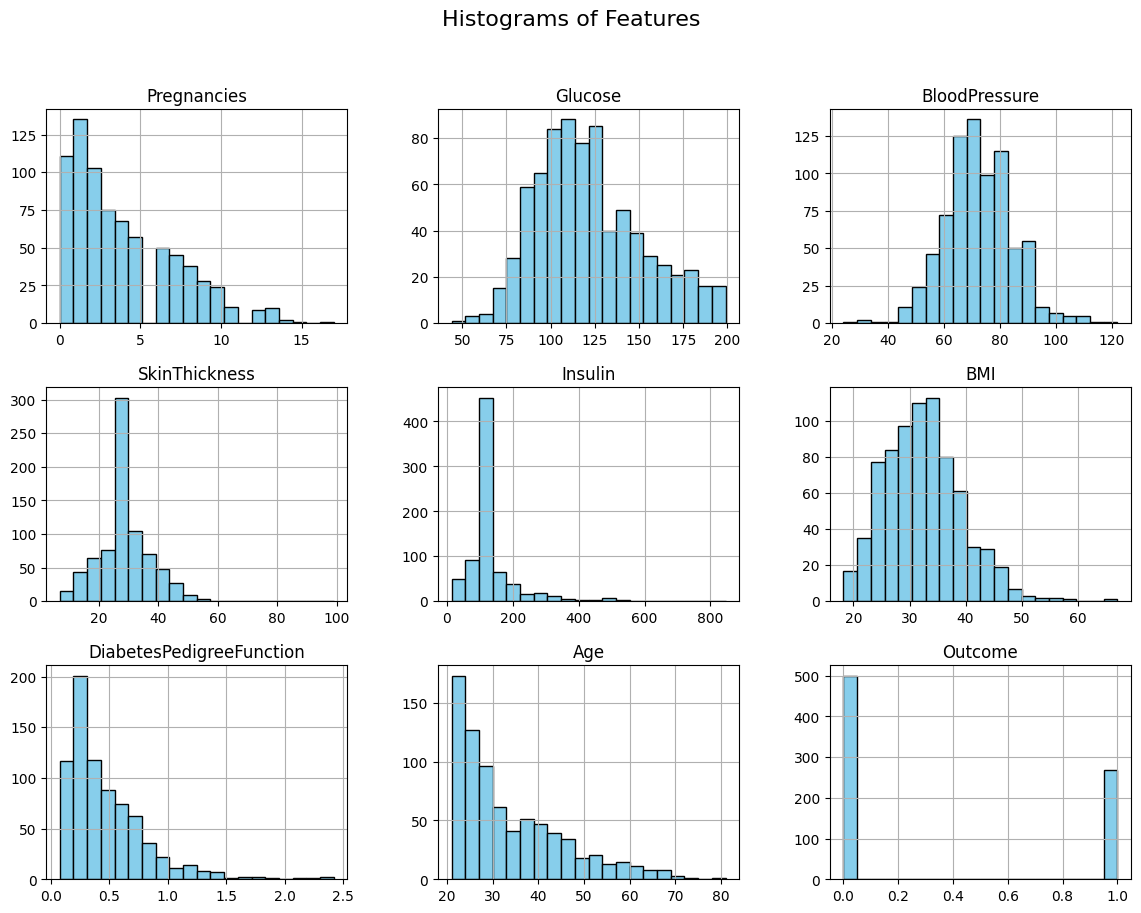

In [32]:
df.hist(bins=20, figsize=(14, 10), color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Features", fontsize=16)
plt.show()

**Correlation heatmap**

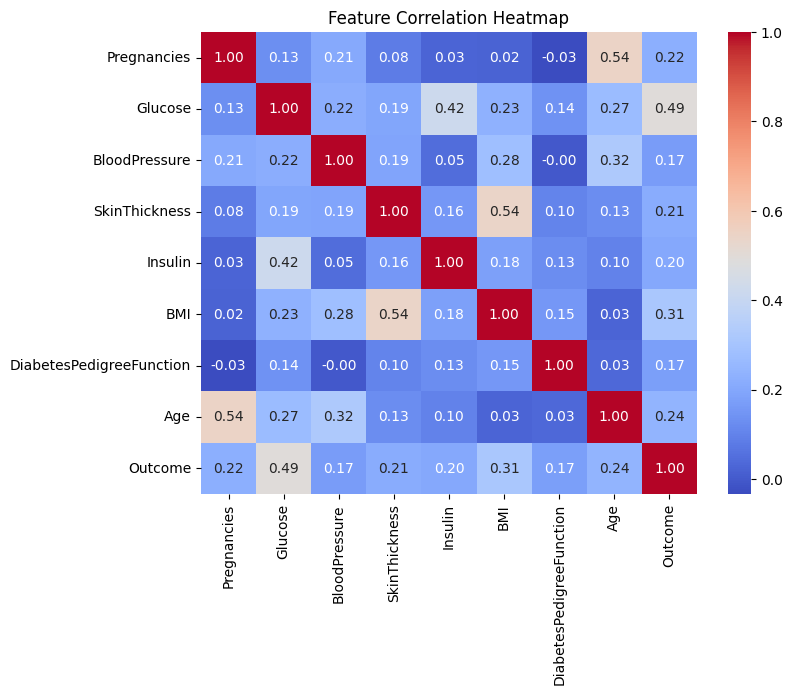

In [33]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

**Diabetes Outcome Count**

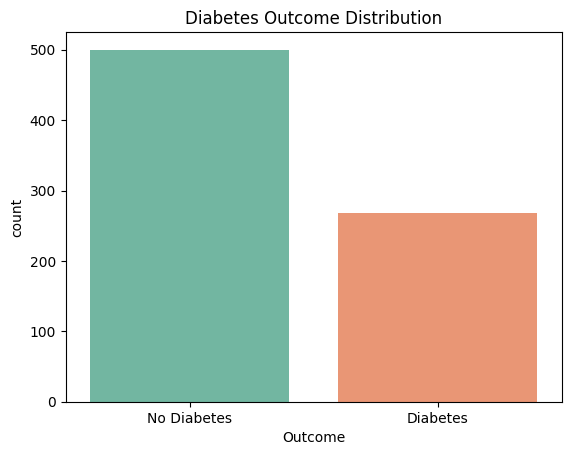

In [34]:
sns.countplot(data=df, x="Outcome", palette="Set2")
plt.title("Diabetes Outcome Distribution")
plt.xticks([0, 1], ["No Diabetes", "Diabetes"])
plt.show()

**Step 5: Split and Scale**

In [35]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Step 6: Apply SMOTE**

In [36]:
smote = SMOTE(random_state=42)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

**Step 7: Define Models**

In [37]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

**Step 8: Train and Evaluation without tuning**

In [38]:
untuned_results = {}

print("Untuned Model Accuracies:")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, pred)
    untuned_results[name] = {"model": model, "accuracy": acc, "prediction": pred}
    print(f"{name}: Accuracy = {acc:.4f}")

best_untuned_name = max(untuned_results, key=lambda x: untuned_results[x]["accuracy"])
best_untuned_model = untuned_results[best_untuned_name]["model"]
best_untuned_accuracy = untuned_results[best_untuned_name]["accuracy"]

print(f"\nBest Untuned Model: {best_untuned_name} with Accuracy = {best_untuned_accuracy:.4f}")


Untuned Model Accuracies:
Logistic Regression: Accuracy = 0.7143
Random Forest: Accuracy = 0.7532
SVM: Accuracy = 0.7273
Decision Tree: Accuracy = 0.7013
KNN: Accuracy = 0.6948
Naive Bayes: Accuracy = 0.6948
Gradient Boosting: Accuracy = 0.7662
AdaBoost: Accuracy = 0.7662

Best Untuned Model: Gradient Boosting with Accuracy = 0.7662


**Step 9: Define Models parameter**

In [39]:
param_grids = {
    "Logistic Regression": {"C": [0.1, 1, 10]},
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [None, 5, 10]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ['linear', 'rbf']},
    "Decision Tree": {"max_depth": [None, 5, 10]},
    "KNN": {"n_neighbors": [3, 5, 7]},
    "Naive Bayes": {},
    "Gradient Boosting": {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]},
    "AdaBoost": {"n_estimators": [50, 100]}
}

**Step 10: Train and Evaluation with tuning**

In [40]:
tuned_results = {}

print("Tuned Model Accuracies:")
for name, model in models.items():
    #print(f"Tuning {name}...")
    grid = param_grids.get(name)
    
    if grid:
        search = GridSearchCV(model, grid, cv=3, scoring='accuracy', n_jobs=-1)
        search.fit(X_train_scaled, y_train)
        best_model = search.best_estimator_
    else:
        best_model = model.fit(X_train_scaled, y_train)

    pred = best_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, pred)
    tuned_results[name] = {"model": best_model, "accuracy": acc, "prediction": pred}
    
    print(f"{name}: Accuracy = {acc:.4f}")

best_tuned_name = max(tuned_results, key=lambda x: tuned_results[x]["accuracy"])
best_tuned_model = tuned_results[best_tuned_name]["model"]
best_tuned_accuracy = tuned_results[best_tuned_name]["accuracy"]

print(f"\nBest Tuned Model: {best_tuned_name} with Accuracy = {best_tuned_accuracy:.4f}")


Tuned Model Accuracies:
Logistic Regression: Accuracy = 0.7143
Random Forest: Accuracy = 0.7532
SVM: Accuracy = 0.7078
Decision Tree: Accuracy = 0.6818
KNN: Accuracy = 0.6948
Naive Bayes: Accuracy = 0.6948
Gradient Boosting: Accuracy = 0.7532
AdaBoost: Accuracy = 0.7403

Best Tuned Model: Random Forest with Accuracy = 0.7532


**Step 11: Compare Accuracy**

In [44]:
model_names = list(models.keys())

accuracy_data = {
    "Model": model_names,
    "Untuned Accuracy": [round(untuned_results[name]["accuracy"], 4) for name in model_names],
    "Tuned Accuracy": [round(tuned_results[name]["accuracy"], 4) for name in model_names]
}

accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df.sort_values("Tuned Accuracy", ascending=False, inplace=True)

print("\nAccuracy Comparison (Untuned vs Tuned):")
print(accuracy_df)



Accuracy Comparison (Untuned vs Tuned):
                 Model  Untuned Accuracy  Tuned Accuracy
1        Random Forest            0.7532          0.7532
6    Gradient Boosting            0.7662          0.7532
7             AdaBoost            0.7662          0.7403
0  Logistic Regression            0.7143          0.7143
2                  SVM            0.7273          0.7078
4                  KNN            0.6948          0.6948
5          Naive Bayes            0.6948          0.6948
3        Decision Tree            0.7013          0.6818


**Compare Accuracy into plot**

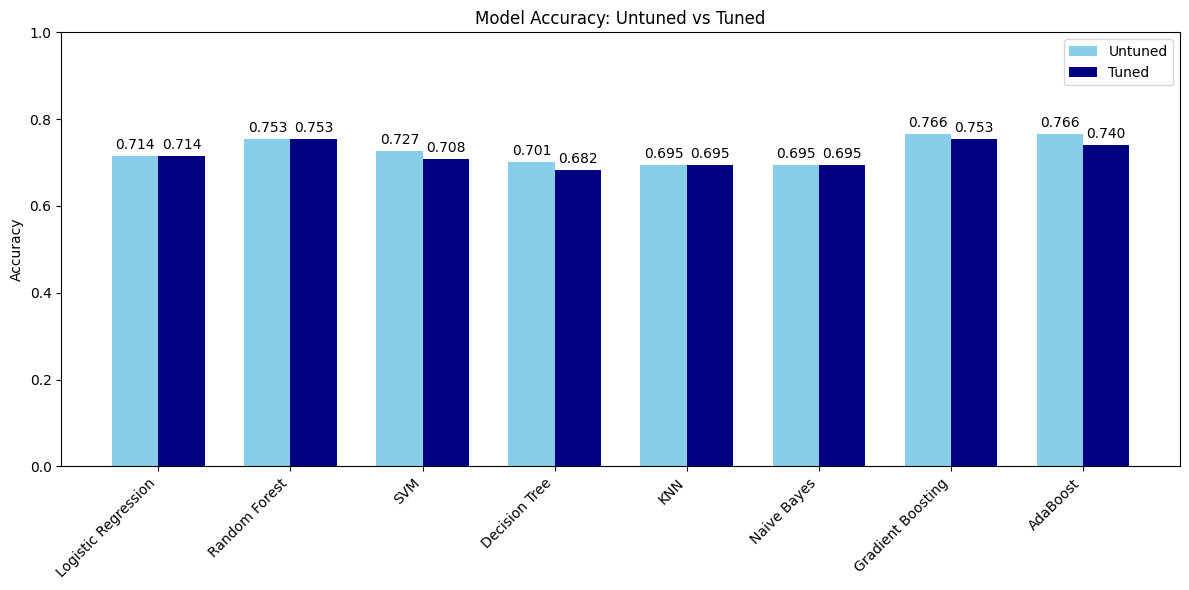

In [41]:
model_names = list(untuned_results.keys())
untuned_accs = [untuned_results[name]['accuracy'] for name in model_names]
tuned_accs = [tuned_results[name]['accuracy'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, untuned_accs, width, label='Untuned', color='skyblue')
rects2 = ax.bar(x + width/2, tuned_accs, width, label='Tuned', color='navy')

ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy: Untuned vs Tuned')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()
ax.bar_label(rects1, fmt='%.3f', padding=3)
ax.bar_label(rects2, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

**Step 12: Confusion Matrix and Classification Report**

Best Untuned Model: Gradient Boosting


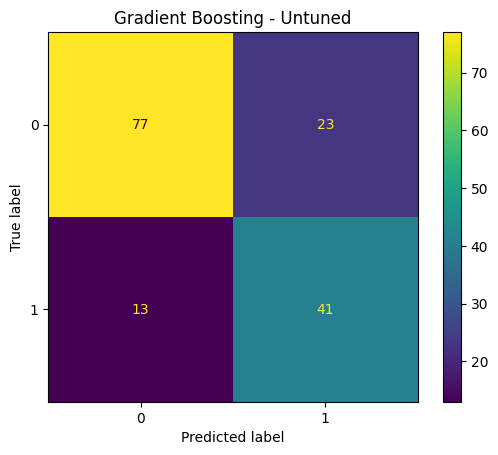

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       100
           1       0.64      0.76      0.69        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.77      0.77       154


Best Tuned Model: Random Forest


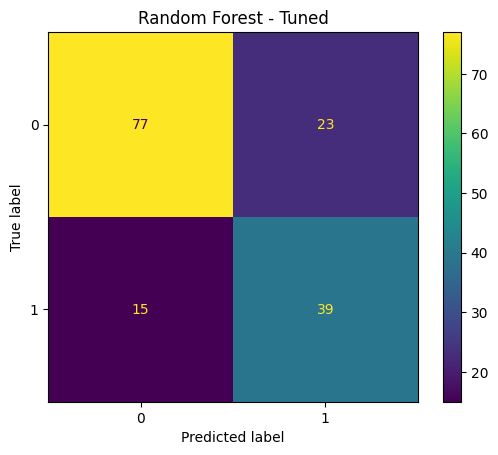

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       100
           1       0.63      0.72      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.76      0.75      0.76       154



In [42]:
print(f"Best Untuned Model: {best_untuned_name}")
ConfusionMatrixDisplay.from_estimator(best_untuned_model, X_test_scaled, y_test)
plt.title(f"{best_untuned_name} - Untuned")
plt.show()
print(classification_report(y_test, best_untuned_model.predict(X_test_scaled)))

print(f"\nBest Tuned Model: {best_tuned_name}")
ConfusionMatrixDisplay.from_estimator(best_tuned_model, X_test_scaled, y_test)
plt.title(f"{best_tuned_name} - Tuned")
plt.show()
print(classification_report(y_test, best_tuned_model.predict(X_test_scaled)))

**Feature Importance**

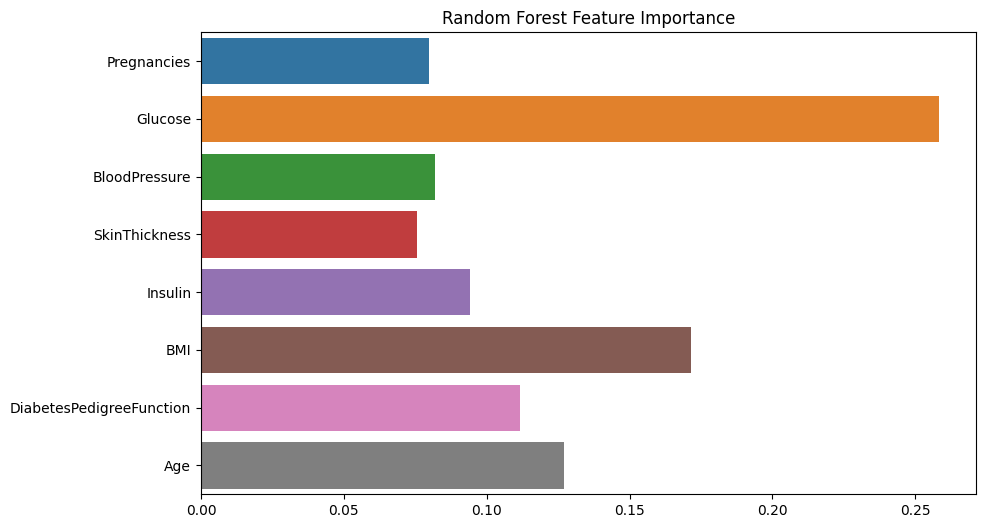

In [43]:
if hasattr(best_tuned_model, "feature_importances_"):
    importances = best_tuned_model.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=X.columns)
    plt.title(f"{best_tuned_name} Feature Importance")
    plt.show()

**Step 13: Prediction**

In [45]:
sample = X_test.iloc[:10]
true_vals = y_test.loc[sample.index]

pred_untuned = best_untuned_model.predict(scaler.transform(sample))
pred_tuned = best_tuned_model.predict(scaler.transform(sample))

comparison_df = pd.DataFrame({
    "Actual Outcome": true_vals.values,
    f"{best_untuned_name} (Untuned)": pred_untuned,
    f"{best_tuned_name} (Tuned)": pred_tuned
})

print("\nTest Set Prediction Comparison:")
print(comparison_df)


Test Set Prediction Comparison:
   Actual Outcome  Gradient Boosting (Untuned)  Random Forest (Tuned)
0               0                            1                      1
1               0                            0                      0
2               0                            0                      0
3               1                            1                      0
4               0                            0                      0
5               0                            0                      0
6               1                            1                      1
7               1                            1                      1
8               0                            0                      0
9               0                            1                      1
